# Analysis of 4D Prostate Images

1. Importing Libraries

In [24]:
import SimpleITK as sitk
import os
import tensorflow as tf
import pandas as pd
import time
import warnings

import imageio
import nibabel as nib
from IPython.display import Image

from tensorflow import keras
from matplotlib import pyplot as plt
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

%matplotlib inline

2. Loading Image Data

In [27]:
t1_fn = 'prostate_00.nii.gz'
image = np.array(nib.load(t1_fn).get_fdata())
image.shape

(320, 320, 15, 2)

In [28]:
label_fn = 'prostate_label_00.nii.gz'

label = np.array(nib.load(label_fn).get_fdata())
label.shape

(320, 320, 15)

In [29]:
from tensorflow.keras.utils import to_categorical
label_cat = to_categorical(label, num_classes=4).astype(np.uint8)
label_cat.shape

(320, 320, 15, 4)

In [30]:
import cv2

image_norm = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
image_norm.shape

(320, 320, 15)

In [31]:
labeled_image = np.zeros_like(label_cat[:, :, :, 1:])

# remove tumor part from image
labeled_image[:, :, :, 0] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 1] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 2] = image_norm * (label_cat[:, :, :, 0])

# color labels
labeled_image += label_cat[:, :, :, 1:] * 255

labeled_image.shape

(320, 320, 15, 3)

In [32]:
data_all = []
data_all.append(labeled_image)
np.array(data_all).shape

(1, 320, 320, 15, 3)

In [33]:
first_plane = np.transpose(data_all, [1,3,2,4,0])
first_plane = np.rot90(first_plane,1)
first_plane.shape

(15, 320, 320, 3, 1)

In [34]:
second_plane = np.transpose(data_all, [2, 1, 3, 4, 0])
second_plane = np.rot90(second_plane,2)
second_plane.shape

(320, 320, 15, 3, 1)

In [35]:
third_plane = np.transpose(data_all, [2, 3, 1, 4, 0])
third_plane = np.rot90(third_plane, 1)
third_plane.shape

(15, 320, 320, 3, 1)

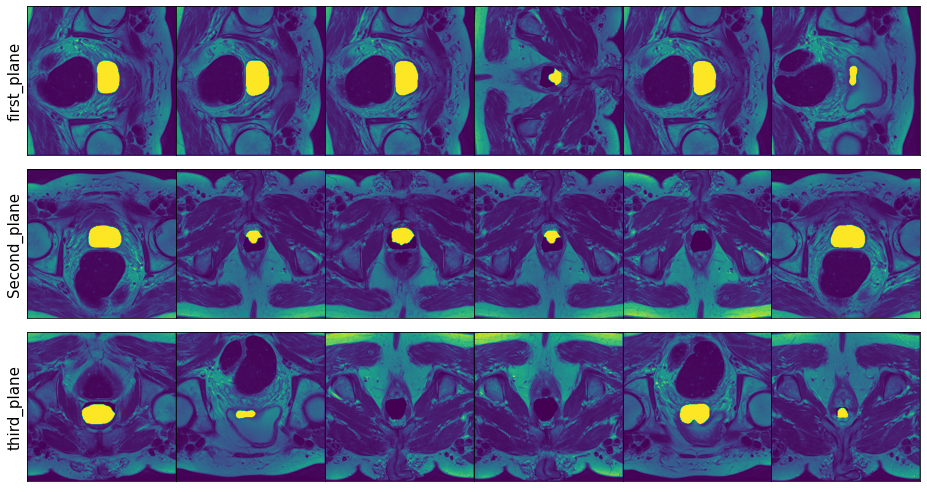

In [36]:
fig, ax = plt.subplots(3, 6, figsize=[16, 9])

for i in range(6):
    n = np.random.randint(1, 15)
    m = np.random.randint(1,2)
    ax[0][i].imshow(np.squeeze(first_plane[n, :, :, m]))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('first_plane', fontsize=15)

for i in range(6):
    n = np.random.randint(1, 15)
    m = np.random.randint(1,3)
    ax[1][i].imshow(np.squeeze(second_plane[:, :, n, m]))
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('Second_plane', fontsize=15)

for i in range(6):
    n = np.random.randint(1, 15)
    m = np.random.randint(1,3)
    ax[2][i].imshow(np.squeeze(third_plane[n, :, :, m]))
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('third_plane', fontsize=15)

fig.subplots_adjust(wspace=0, hspace=0)

In [37]:
def get_sub_volume(image, label, 
                   orig_x = 320, orig_y = 320, orig_z = 15, 
                   output_x = 210, output_y = 210, output_z = 2,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    
    X = None
    y = None

    tries = 0    
    while tries < max_tries:
        start_x = np.random.randint(0, orig_x - output_x+1) 
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        tries += 1

        if bgrd_ratio < background_threshold:
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])

            X = np.moveaxis(X, 3, 0)
            y = np.moveaxis(y, 3, 0)
            y = y[1:, :, :, :]
    
            return X, y

    print("Tried {} times to find a sub-volume. Giving up...".format(tries))

In [38]:
np.random.seed(3)

image = np.zeros((4, 4, 3, 1))
label = np.zeros((4, 4, 3))
for i in range(4):
    for j in range(4):
        for k in range(3):
            image[i, j, k, 0] = i*j*k
            label[i, j, k] = k

print("image:")
for k in range(3):
    print(f"z = {k}")
    print(image[:, :, k, 0])
print("\n")
print("label:")
for k in range(3):
    print(f"z = {k}")
    print(label[:, :, k])

image:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[0. 0. 0. 0.]
 [0. 1. 2. 3.]
 [0. 2. 4. 6.]
 [0. 3. 6. 9.]]
z = 2
[[ 0.  0.  0.  0.]
 [ 0.  2.  4.  6.]
 [ 0.  4.  8. 12.]
 [ 0.  6. 12. 18.]]


label:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
z = 2
[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


In [39]:
sample_image, sample_label = get_sub_volume(image, 
                                            label,
                                            orig_x=4, 
                                            orig_y=4, 
                                            orig_z=3,
                                            output_x=2, 
                                            output_y=2, 
                                            output_z=2,
                                            num_classes = 3)

print("Sampled Image:")
for k in range(2):
    print("z = " + str(k))
    print(sample_image[0, :, :, k])

Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]


In [40]:
# set home directory and data directory
HOME_DIR = "./Task05_Prostate/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [41]:
image, label = load_case(DATA_DIR + "imagesTr/prostate_00.nii.gz", DATA_DIR + "LabelsTr/prostate_00.nii.gz")
X, y = get_sub_volume(image, label)

In [42]:
X.shape

(2, 210, 210, 2)

In [43]:
y.shape

(3, 210, 210, 2)

In [44]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

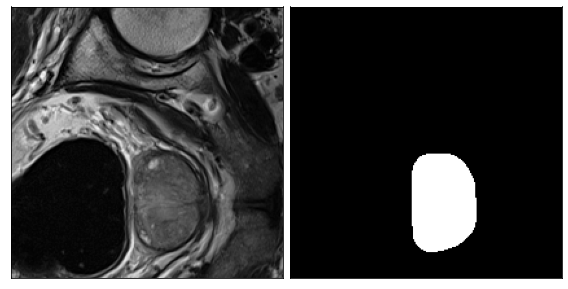

In [45]:
visualize_patch(X[0, :, :, :], y[1])

Standardization:

In [46]:
def standardize(image):
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean
            centered = image_slice - np.mean(image_slice)

            # divide by the standard deviation
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled


    return standardized_image

In [47]:
X_norm = standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


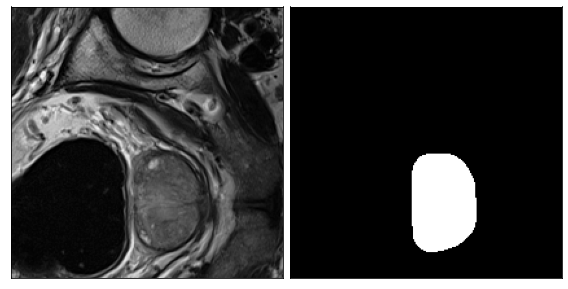

In [48]:
visualize_patch(X_norm[0, :, :, :], y[1])